In [1]:
#use Google Coolab with free GPU to train model
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import time
import copy

from typing import Iterable
from dataclasses import dataclass

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [0]:
#LeNet with Batch Normalization
class LeNetBN(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),
            
            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weight in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            
            # ReLU activation
            nn.ReLU(inplace=True),
            
            # Third fully connected layer. It is also output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x


In [4]:
model = LeNetBN()
print(model)

LeNetBN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


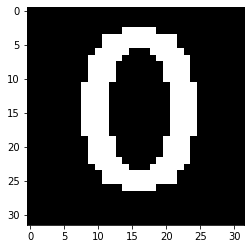

In [5]:
#generate diferent image of digits bby OpenCV
train_aug = []
for digit in range(10):
    for font in [0,2,3,4,6,7]:
        for scale in [0.8, 1.0]:
            for color in [70, 100, 120, 160, 200, 220, 255]:
                for thik in [0,1,2]:
                    for line in [cv2.FILLED, cv2.LINE_4, cv2.LINE_8, cv2.LINE_AA]:
                        img = np.zeros((32,32), dtype=np.uint8)
                        img = cv2.putText(img, str(digit), (6,25), font, scale, color, thik, line)
                        if(len(train_aug)==500):
                          #for example
                          plt.imshow(img,'gray');plt.show()
                        train_aug.append((transforms.Normalize((0.0664, ), (0.2043, ))(transforms.ToTensor()(img)), digit)) #transform to tensor and normalize. put in list

In [6]:
len(train_aug)

10080

In [7]:
test_aug = []
for digit in range(10):
    for scale in [0.8, 1.0]:
        for color in [70, 100, 120, 160, 200, 220, 255]:
            for thik in [0,1,2]:
                for line in [cv2.FILLED, cv2.LINE_4, cv2.LINE_8, cv2.LINE_AA]:
                    img = np.zeros((32,32), dtype=np.uint8)
                    img = cv2.putText(img, str(digit), (6,25), 16, scale, color, thik, line)
                    #plt.imshow(img,'gray');plt.show()
                    test_aug.append((transforms.Normalize((0.0664, ), (0.2043, ))(transforms.ToTensor()(img)), digit))#transform to tensor and normalize. put in list
print(len(test_aug))

1680


In [0]:
torch.manual_seed(42)
#if torch.cuda.is_available():
#    torch.backend.cudnn_benchmark_enabled = True
#    torch.backend.cudnn.deterministic = True

#training parameters
batch_size = 32
epochs_count = 20
learning_rate = 0.01
log_interval = 100
test_interval = 1
num_workers  = 10
device = 'cuda'

In [9]:
if torch.cuda.is_available():
    device = "cuda"
    print('GPU')
else:
    device = "cpu"
    batch_size = 16
    num_workers = 0
    epochs_count = 10
    print('CPU')

model.to(device)

#SGDoptimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

#array for plotting
best_loss = torch.tensor(np.inf)

# epoch train/test loss
epoch_train_loss = np.array([])
epoch_test_loss = np.array([])

# epch train/test accuracy
epoch_train_acc = np.array([])
epoch_test_acc = np.array([])

GPU


In [0]:
# train dataloader
train_loader_aug = torch.utils.data.DataLoader(
     train_aug,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
# test dataloader
test_loader_aug = torch.utils.data.DataLoader(
    test_aug,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [0]:
def train(model, optimizer, train_loader, epoch_idx):
    # change model in training mood
    model.train()

    # to get batch loss
    batch_loss = np.array([])

    # to get batch accuracy
    batch_acc = np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):

        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(device)
        # send target to device
        target = target.to(device)

        # reset parameters gradient to zero
        optimizer.zero_grad()

        # forward pass to the model
        output = model(data)

        # cross entropy loss
        loss = F.cross_entropy(output, target)

        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()

        batch_loss = np.append(batch_loss, [loss.item()])

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()

        # accuracy
        acc = float(correct) / float(len(data))

        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % log_interval == 0 and batch_idx > 0:
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )

    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc


def validate(model, test_loader):
    #
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(device)

        target = target.to(device)

        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)

    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy / 100.0


In [12]:
#train
t_begin = time.time()
#for save best model
best_model = copy.deepcopy(model)
for epoch in range(epochs_count):

    train_loss, train_acc = train(model, optimizer, train_loader_aug, epoch)

    epoch_train_loss = np.append(epoch_train_loss, [train_loss])

    epoch_train_acc = np.append(epoch_train_acc, [train_acc])

    elapsed_time = time.time() - t_begin
    speed_epoch = elapsed_time / (epoch + 1)
    speed_batch = speed_epoch / len(train_loader_aug)
    eta = speed_epoch * epochs_count - elapsed_time

    print(
        "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
            elapsed_time, speed_epoch, speed_batch, eta
        )
    )

    if epoch % test_interval == 0:
        current_loss, current_accuracy = validate(model, test_loader_aug)

        epoch_test_loss = np.append(epoch_test_loss, [current_loss])

        epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

        if current_loss < best_loss:
            best_loss = current_loss
            best_model = copy.deepcopy(model)

Train Epoch: 0 [3200/10080] Loss: 2.066944 Acc: 0.5000
Train Epoch: 0 [6400/10080] Loss: 1.460785 Acc: 0.8750
Train Epoch: 0 [9600/10080] Loss: 0.705623 Acc: 1.0000
Elapsed 1.83s, 1.83 s/epoch, 0.01 s/batch, ets 34.83s

Test set: Average loss: 0.5651, Accuracy: 1680/1680 (100%)

Train Epoch: 1 [3200/10080] Loss: 0.318583 Acc: 0.9688
Train Epoch: 1 [6400/10080] Loss: 0.171680 Acc: 1.0000
Train Epoch: 1 [9600/10080] Loss: 0.088264 Acc: 1.0000
Elapsed 4.15s, 2.08 s/epoch, 0.01 s/batch, ets 37.36s

Test set: Average loss: 0.0904, Accuracy: 1680/1680 (100%)

Train Epoch: 2 [3200/10080] Loss: 0.045851 Acc: 1.0000
Train Epoch: 2 [6400/10080] Loss: 0.058695 Acc: 1.0000
Train Epoch: 2 [9600/10080] Loss: 0.028536 Acc: 1.0000
Elapsed 6.49s, 2.16 s/epoch, 0.01 s/batch, ets 36.79s

Test set: Average loss: 0.0341, Accuracy: 1680/1680 (100%)

Train Epoch: 3 [3200/10080] Loss: 0.019477 Acc: 1.0000
Train Epoch: 3 [6400/10080] Loss: 0.030600 Acc: 1.0000
Train Epoch: 3 [9600/10080] Loss: 0.034936 Acc: 1.

In [13]:
print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

Total time: 46.14, Best Loss: 0.001


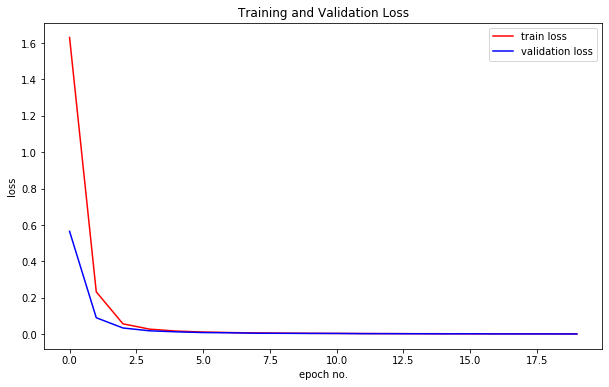

In [14]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))

plt.plot(x, epoch_train_loss, 'r', label="train loss")
plt.plot(x, epoch_test_loss, 'b',label="validation loss")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#save model with best loss
torch.save(best_model.state_dict(), '../content/gdrive/My Drive/models/aug_model.pth')

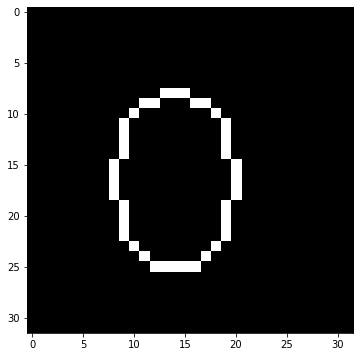

Predicted class 0 with probability 0.9999929666519165


In [16]:
#download and test model
model = LeNetBN()
model.load_state_dict(torch.load('../content/gdrive/My Drive/models/aug_model.pth'))
#print(model1)
images, labels = next(iter(test_loader_aug))
plt.imshow(images[0][0],'gray')
image = images[0,:]#.to(device)
image = image[None]
plt.show()
score = model(image)
prob = nn.functional.softmax(score[0], dim=0)
y_pred =  prob.argmax()
print("Predicted class {} with probability {}".format(y_pred, prob[y_pred]))

In [0]:
import pandas as pd
test = pd.read_csv("../content/gdrive/My Drive/MNIST/test.csv")
test_image = test.loc[:,test.columns != "label"]
test_dataset = torch.from_numpy(np.reshape(test_image.to_numpy().astype(np.uint8), (test_image.shape[0], 1, 28,28)))
results = []
with torch.no_grad():
    model.eval()
    for img in test_dataset:
        img = transforms.ToPILImage()(img)
        img = transforms.Resize((32, 32))(img)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize((0.0664, ), (0.2043, ))(img)
        test_im = img#.to(device)
        test_im = test_im[None]
        output = model(test_im)
        prob = nn.functional.softmax(output[0], dim=0)
        y_pred =  prob.argmax()
        results.append( y_pred.cpu().data.numpy().tolist())

In [18]:
len(results)

28000

In [0]:
predictions = np.array(results).flatten()
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("../content/gdrive/My Drive/MNIST/my_submissions04.csv", index=False, header=True)